### Classificador de spam with naive_bayes

link útil: https://scikit-learn.org/stable/modules/feature_extraction.html

###### Bibliotecas

In [1]:
import pandas as pd
import re
import string
import nltk

from nltk import FreqDist

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt 

from sklearn.feature_extraction.text import CountVectorizer#, TfidfVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

###### Carregando base
CSV obtido no curso Machine Learning para cientista de dados da Data Science Academy (DSA)

In [2]:
df = pd.read_csv('sms_spam.csv')
print('shape:',df.shape)
df.head()

shape: (5559, 2)


,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [3]:
df.dtypes

type    object
text    object
dtype: object

###### Funções de pre processamento dos textos

In [5]:
def remove_stopwords(text):
    '''
    Funcao para remover stopwords em inglês
    input:
        text: string
    output:
        string
    '''
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english') #define aqui que é 'english'
    stopwords.extend(stopwords)
    #stopwords.extend(stop_pt)
    
    return ' '.join([word for word in str(text).split() if word not in stopwords])

In [6]:
def trata_texto(text, transform_numbers=True):
    '''
    Funcao para tratamento textual.
        text: string
        output: string
    '''
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.replace('\xa0', ' ')
    
    re_transform_numbers = re.compile(r'\d', re.UNICODE)
    if transform_numbers:
        text = re_transform_numbers.sub('0', text)

    return text.strip()

In [8]:
def Stemming(text):
    '''
    Função para aplicação do processo de stemização.
    É o processo de reduzir palavras flexionadas (ou às vezes derivadas) ao seu tronco (stem), base ou raiz, 
    geralmente uma forma da palavra escrita.
    Exemplo em inglês:
        studies
            sufixo: es
            stem: studi
    '''
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in text.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

#### Aplicando funções

In [10]:
%%time
text_tratado = df['text'].apply(trata_texto).apply(remove_stopwords).apply(Stemming)
text_tratado[:5]

Wall time: 30.6 s


In [11]:
len(text_tratado)

5559

#### Guardando texto em uma lista só

In [12]:
corpus = " ".join(text for text in text_tratado)

#### Palavras que mais aparecem
    'u' aparece mais, tem que entrar mais a fundo pra entender se tem um significado ou se era pra ser uma stop words. 
    'u' de you?

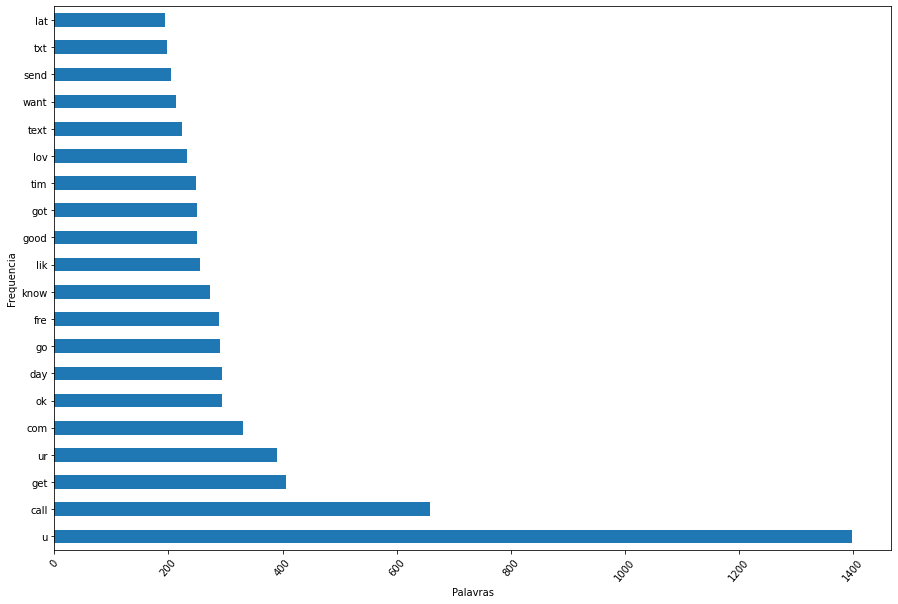

In [13]:
token_corpus = corpus.split()
freq = FreqDist(token_corpus)
df_freq = pd.DataFrame.from_dict(freq, orient='index')
df_freq.columns = ['Frequência']
df_freq.index.name = 'Palavra'
df_freq.sort_values(ascending = False, by = 'Frequência')

plt.figure(figsize=(15,10))
df_freq['Frequência'].sort_values(ascending=False).head(20).plot.barh()
plt.xticks(rotation=50)
plt.xlabel("Palavras")
plt.ylabel("Frequencia")
plt.show()

#### Wordcloud

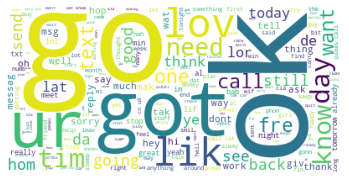

In [14]:
# Criando e gerando WordCloud
wordcloud = WordCloud(background_color="white").generate(corpus)

# Display:
plt.imshow(wordcloud)#, interpolation='bilinear')
plt.axis("off")
plt.show()

### ---------------------------------------------------------------------------------------------------------------------------------------------------------
## Vetorizando - Bag of Words
    tokenizing - quebrar uma frase em palavras
    texto vira parágrafos >> parágrafos vira frase >> frase vira palavra
   **CountVectorizer** vai gerar um vetor com essas contagens

In [16]:
count_vector = CountVectorizer(max_features=2500) #cria o objeto
X = count_vector.fit_transform(text_tratado).toarray() #passa o texto "tratado, póps aplicação das funções
X.shape

y  = df['type']

###### ------------------------------------
######  (******) Início parênteses 
   **Entendendo tokenizing**

In [17]:
analyze = count_vector.build_analyzer()
analyze("This is a text document to analyze.")

['this', 'is', 'text', 'document', 'to', 'analyze']

In [18]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
count_vector.vocabulary_.get('document')

In [20]:
count_vector.vocabulary_.get('ok')

1487

In [21]:
count_vector.vocabulary_.get('go')

849

In [22]:
count_vector.vocabulary_.get('nathalia')

In [23]:
text_tratado[0]

'hop good week checking'

In [24]:
count_vector.transform(['hop good week . checking']).toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

######  (******) Fim parênteses 
###### ------------------------------------

## Train Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

###### Verificando proporção

In [26]:
print('treino:\n', y_train.value_counts(normalize=True))
print('\nteste:\n', y_test.value_counts(normalize=True))

treino:
 ham     0.865527
spam    0.134473
Name: type, dtype: float64

teste:
 ham     0.866007
spam    0.133993
Name: type, dtype: float64


### Treinando o modelo usando Naive Bayes Classifier

###### Instanciando

In [27]:
spam_model = MultinomialNB().fit(X_train, y_train) #alpha=0 --laplace

###### predict

In [28]:
y_pred = spam_model.predict(X_test)

###### Performance

In [29]:
print(metrics.classification_report(y_test, y_pred,target_names=df.type.unique()))

              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       963
        spam       0.89      0.93      0.91       149

    accuracy                           0.97      1112
   macro avg       0.94      0.95      0.95      1112
weighted avg       0.98      0.97      0.98      1112



In [30]:
metrics.confusion_matrix(y_test, y_pred)

array([[946,  17],
       [ 11, 138]], dtype=int64)

end